In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Load data
df = pd.read_csv('/home/daksh/Downloads/pumpfun_09-08-2025_to_09-11-2025.csv/pumpfun_09-08-2025_to_09-11-2025.csv')
# Normalize column names to avoid trailing/leading spaces
df.columns = df.columns.str.strip()

# Input: Token address to analyze
TOKEN_ADDRESS = 'CsKfV8ePhQWiyQxNJwXhKZHcmUyNWBkHFGrkZGdJpump'

# Filter and prepare data
token_data = df[df['Token Address'] == TOKEN_ADDRESS].copy()

# Identify a timestamp column robustly
possible_cols = [
    'DateBlock ID', 'Date Block ID', 'Timestamp', 'Time', 'Block Time',
    'Date', 'Datetime', 'datetime', 'timestamp', 'time'
]
timestamp_col = next((c for c in possible_cols if c in token_data.columns), None)

if timestamp_col is None:
    # Fallback: try to auto-detect any datetime-like column
    for c in token_data.columns:
        try:
            pd.to_datetime(token_data[c])
            timestamp_col = c
            break
        except Exception:
            continue

if timestamp_col is None:
    raise KeyError(
        f"No timestamp-like column found. Available columns: {list(token_data.columns)}"
    )

# Create normalized timestamp
token_data['timestamp'] = pd.to_datetime(token_data[timestamp_col])

# Ensure numeric types for price-like fields to avoid aggregation dtype issues
if 'Token Price' in token_data.columns:
    token_data['Token Price'] = pd.to_numeric(token_data['Token Price'], errors='coerce')

token_data = token_data.sort_values('timestamp').reset_index(drop=True)

print(f"\n{'='*70}")
print(f"PUMP & BUY FREQUENCY ANALYSIS")
print(f"Token: {TOKEN_ADDRESS}")
print(f"{'='*70}")
print(f"Total transactions: {len(token_data)}")
print(f"Time range: {token_data['timestamp'].min()} to {token_data['timestamp'].max()}")
print(f"Duration: {(token_data['timestamp'].max() - token_data['timestamp'].min()).total_seconds() / 3600:.2f} hours")




PUMP & BUY FREQUENCY ANALYSIS
Token: CsKfV8ePhQWiyQxNJwXhKZHcmUyNWBkHFGrkZGdJpump
Total transactions: 239046
Time range: 2025-09-10 18:35:28+00:00 to 2025-09-12 20:08:26+00:00
Duration: 49.55 hours


In [20]:
# ============================================================================
# STEP 1: IDENTIFY PUMP PERIODS
# ============================================================================

# Define pump: significant price increase over short time window
ROLLING_WINDOW = '30S'  # 30 second rolling window
PUMP_THRESHOLD = 5.0    # 5% price increase = pump

# Ensure timestamp exists; reconstruct if needed
if 'timestamp' not in token_data.columns:
    possible_cols = [
        'DateBlock ID', 'Date Block ID', 'Timestamp', 'Time', 'Block Time',
        'Date', 'Datetime', 'datetime', 'timestamp', 'time'
    ]
    ts_col = next((c for c in possible_cols if c in token_data.columns), None)
    if ts_col is None:
        for c in token_data.columns:
            try:
                pd.to_datetime(token_data[c])
                ts_col = c
                break
            except Exception:
                continue
    if ts_col is None:
        raise KeyError(
            f"No timestamp-like column found. Available columns: {list(token_data.columns)}"
        )
    token_data['timestamp'] = pd.to_datetime(token_data[ts_col])

# Coerce price numeric and sort by time
if 'Token Price' in token_data.columns:
    token_data['Token Price'] = pd.to_numeric(token_data['Token Price'], errors='coerce')

token_data = token_data.sort_values('timestamp').reset_index(drop=True)

# Calculate rolling price changes
token_data.set_index('timestamp', inplace=True)
token_data['rolling_price_max'] = token_data['Token Price'].rolling(ROLLING_WINDOW).max()
token_data['rolling_price_min'] = token_data['Token Price'].rolling(ROLLING_WINDOW).min()
token_data['rolling_price_change'] = ((token_data['rolling_price_max'] - token_data['rolling_price_min']) / 
                                       token_data['rolling_price_min']) * 100

# Identify pump periods
token_data['is_pump'] = token_data['rolling_price_change'] >= PUMP_THRESHOLD

# Also use a simpler definition: consecutive price increases
token_data['price_change'] = token_data['Token Price'].pct_change() * 100
token_data['is_price_rising'] = token_data['price_change'] > 0

# Combine definitions for robust pump detection
token_data['pump_period'] = token_data['is_pump'] | (
    token_data['price_change'] > 2.0  # Single jump > 2%
)

token_data.reset_index(inplace=True)

pump_count = token_data['pump_period'].sum()
print(f"\nPump periods detected: {pump_count} ({pump_count/len(token_data)*100:.2f}% of data)")




Pump periods detected: 168122 (70.33% of data)


/tmp/ipykernel_2548440/167184025.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  token_data['rolling_price_max'] = token_data['Token Price'].rolling(ROLLING_WINDOW).max()
/tmp/ipykernel_2548440/167184025.py:39: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  token_data['rolling_price_min'] = token_data['Token Price'].rolling(ROLLING_WINDOW).min()


In [ ]:
# ============================================================================
# STEP 2: CALCULATE BUY FREQUENCY IN TIME WINDOWS
# ============================================================================

# Create time windows (e.g., 1-minute bins)
TIME_WINDOW = '60S'  # 1 minute bins
token_data.set_index('timestamp', inplace=True)

# Count buys per time window
buy_data = token_data[token_data['Transaction Type'] == 'Buy'].copy()
buy_frequency = buy_data.resample(TIME_WINDOW).size()

# Build a resample index from a known numeric series to avoid object-dtype aggregation
resample_index = token_data.resample(TIME_WINDOW)['Token Price'].mean().index
buy_frequency = buy_frequency.reindex(resample_index, fill_value=0)

# Average price per window
avg_price = token_data.resample(TIME_WINDOW)['Token Price'].mean()
price_change = avg_price.pct_change() * 100

# Identify pump windows
pump_windows = token_data.resample(TIME_WINDOW)['pump_period'].max()  # If any pump in window

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'buy_count': buy_frequency,
    'avg_price': avg_price,
    'price_change': price_change,
    'is_pump': pump_windows
})

analysis_df = analysis_df.dropna()

/tmp/ipykernel_2548440/2354234537.py:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  buy_frequency = buy_data.resample(TIME_WINDOW).size()
/tmp/ipykernel_2548440/2354234537.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resample_index = token_data.resample(TIME_WINDOW)['Token Price'].mean().index
/tmp/ipykernel_2548440/2354234537.py:18: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  avg_price = token_data.resample(TIME_WINDOW)['Token Price'].mean()
/tmp/ipykernel_2548440/2354234537.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_change = avg_price.pct_change() * 100
/tmp/ipykernel_2548440/2354234537.py:22: FutureW

In [22]:
# ============================================================================
# STEP 3: STATISTICAL ANALYSIS
# ============================================================================

pump_periods = analysis_df[analysis_df['is_pump'] == True]
non_pump_periods = analysis_df[analysis_df['is_pump'] == False]

print(f"\n{'='*70}")
print("BUY FREQUENCY COMPARISON")
print(f"{'='*70}")

print(f"\nDuring PUMP periods ({len(pump_periods)} windows):")
print(f"  Average buy count per {TIME_WINDOW}: {pump_periods['buy_count'].mean():.2f}")
print(f"  Median buy count: {pump_periods['buy_count'].median():.2f}")
print(f"  Max buy count: {pump_periods['buy_count'].max():.0f}")
print(f"  Total buys: {pump_periods['buy_count'].sum():.0f}")

print(f"\nDuring NON-PUMP periods ({len(non_pump_periods)} windows):")
print(f"  Average buy count per {TIME_WINDOW}: {non_pump_periods['buy_count'].mean():.2f}")
print(f"  Median buy count: {non_pump_periods['buy_count'].median():.2f}")
print(f"  Max buy count: {non_pump_periods['buy_count'].max():.0f}")
print(f"  Total buys: {non_pump_periods['buy_count'].sum():.0f}")

# Calculate frequency increase
if non_pump_periods['buy_count'].mean() > 0:
    frequency_increase = ((pump_periods['buy_count'].mean() - non_pump_periods['buy_count'].mean()) / 
                          non_pump_periods['buy_count'].mean()) * 100
    print(f"\n🔥 Buy frequency increases by {frequency_increase:.1f}% during pumps!")
else:
    print("\n⚠️  Insufficient non-pump data for comparison")

# Statistical significance test
if len(pump_periods) > 1 and len(non_pump_periods) > 1:
    # Mann-Whitney U test (non-parametric, better for count data)
    u_stat, p_value = stats.mannwhitneyu(pump_periods['buy_count'], 
                                          non_pump_periods['buy_count'], 
                                          alternative='greater')
    
    print(f"\n{'='*70}")
    print("STATISTICAL SIGNIFICANCE")
    print(f"{'='*70}")
    print(f"Mann-Whitney U test p-value: {p_value:.6f}")
    
    if p_value < 0.001:
        print("✓✓✓ EXTREMELY SIGNIFICANT - Very strong evidence for increased buy frequency during pumps")
    elif p_value < 0.01:
        print("✓✓ HIGHLY SIGNIFICANT - Strong evidence for increased buy frequency during pumps")
    elif p_value < 0.05:
        print("✓ SIGNIFICANT - Evidence supports increased buy frequency during pumps")
    else:
        print("✗ NOT SIGNIFICANT - Insufficient evidence for increased buy frequency during pumps")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((pump_periods['buy_count'].std()**2 + non_pump_periods['buy_count'].std()**2) / 2)
    if pooled_std > 0:
        cohens_d = (pump_periods['buy_count'].mean() - non_pump_periods['buy_count'].mean()) / pooled_std
        print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")
        if abs(cohens_d) > 0.8:
            print("  → Large effect size")
        elif abs(cohens_d) > 0.5:
            print("  → Medium effect size")
        elif abs(cohens_d) > 0.2:
            print("  → Small effect size")


BUY FREQUENCY COMPARISON

During PUMP periods (1127 windows):
  Average buy count per 60S: 94.45
  Median buy count: 30.00
  Max buy count: 1447
  Total buys: 106450

During NON-PUMP periods (1829 windows):
  Average buy count per 60S: 11.55
  Median buy count: 7.00
  Max buy count: 90
  Total buys: 21133

🔥 Buy frequency increases by 717.5% during pumps!

STATISTICAL SIGNIFICANCE
Mann-Whitney U test p-value: 0.000000
✓✓✓ EXTREMELY SIGNIFICANT - Very strong evidence for increased buy frequency during pumps

Effect size (Cohen's d): 0.642
  → Medium effect size



LEAD-LAG ANALYSIS: Does buy frequency PREDICT or FOLLOW pumps?

Buy frequency (buys/second):
  BEFORE pump: inf
  DURING pump: inf
  AFTER pump: inf
  Baseline (no pump): inf

→ Buy frequency is elevated throughout pump periods


/tmp/ipykernel_2548440/493477126.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_box, labels=['Non-Pump', 'Pump'], patch_artist=True)


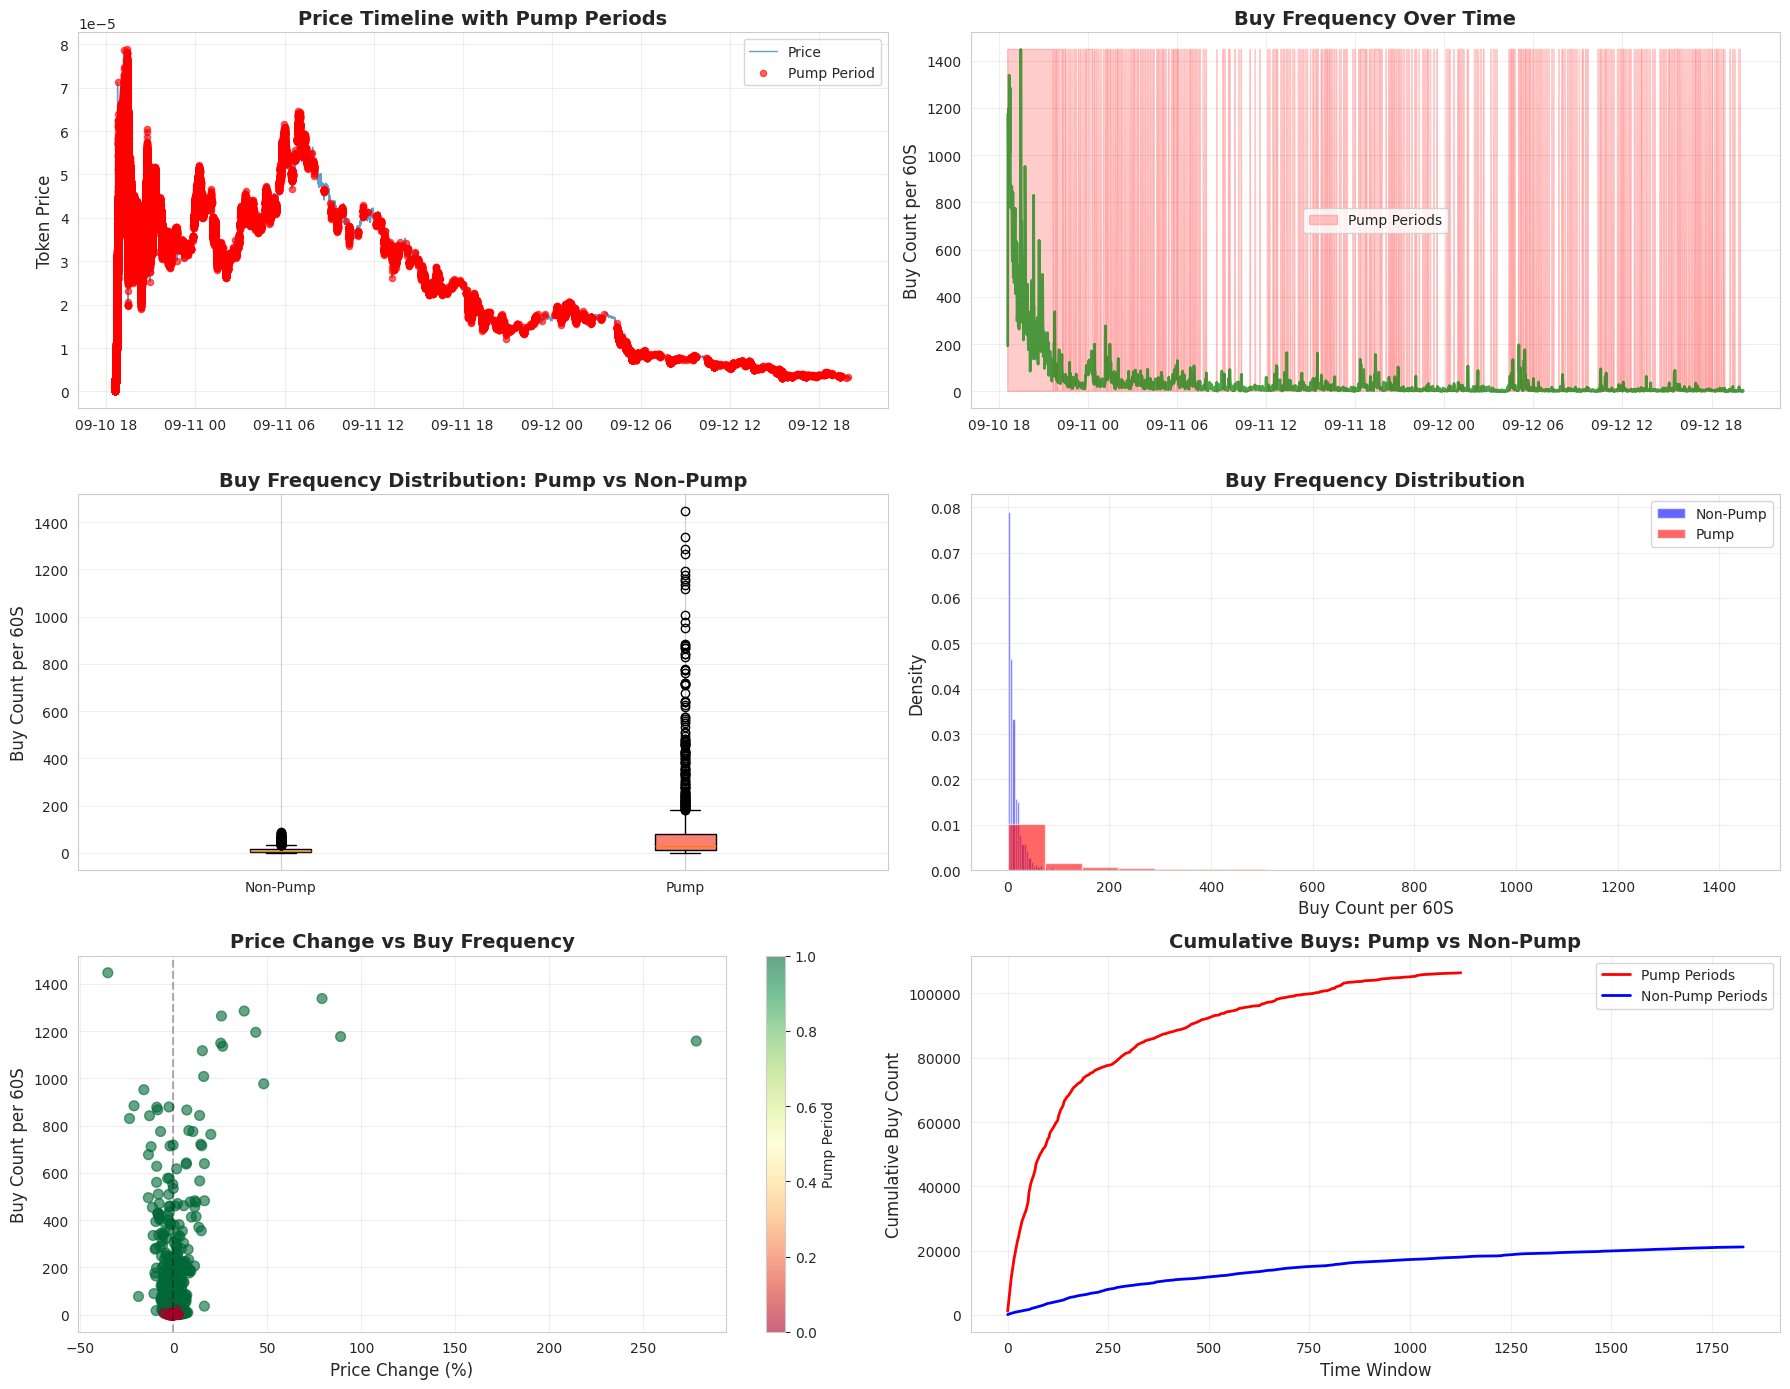


CONCLUSION

📊 Your theory: 'Buy frequency increases during pumps'

Result: Buy frequency is 8.17x higher during pumps

✓ THEORY CONFIRMED - Strong evidence that buy frequency significantly
  increases during pump periods (8.17x increase, p=0.0000)


In [23]:


# ============================================================================
# STEP 4: LEAD-LAG ANALYSIS
# ============================================================================

print(f"\n{'='*70}")
print("LEAD-LAG ANALYSIS: Does buy frequency PREDICT or FOLLOW pumps?")
print(f"{'='*70}")

# Check if increased buy frequency happens BEFORE or AFTER price pumps
token_data.reset_index(inplace=True)
token_data['time_diff'] = token_data['timestamp'].diff().dt.total_seconds()
token_data['buys_per_second'] = 1 / token_data['time_diff']  # Instantaneous buy rate

# For each pump, look at buy frequency before and after
buy_only = token_data[token_data['Transaction Type'] == 'Buy'].copy()
buy_only['future_pump'] = buy_only['pump_period'].shift(-5)  # Next 5 trades
buy_only['past_pump'] = buy_only['pump_period'].shift(5)     # Previous 5 trades

before_pump_freq = buy_only[buy_only['future_pump'] == True]['buys_per_second'].mean()
after_pump_freq = buy_only[buy_only['past_pump'] == True]['buys_per_second'].mean()
baseline_freq = buy_only[buy_only['pump_period'] == False]['buys_per_second'].mean()

print(f"\nBuy frequency (buys/second):")
print(f"  BEFORE pump: {before_pump_freq:.6f}")
print(f"  DURING pump: {buy_only[buy_only['pump_period'] == True]['buys_per_second'].mean():.6f}")
print(f"  AFTER pump: {after_pump_freq:.6f}")
print(f"  Baseline (no pump): {baseline_freq:.6f}")

if before_pump_freq > after_pump_freq * 1.2:
    print("\n→ Buy frequency INCREASES BEFORE pumps (predictive buying)")
elif after_pump_freq > before_pump_freq * 1.2:
    print("\n→ Buy frequency INCREASES AFTER pumps start (reactive buying/FOMO)")
else:
    print("\n→ Buy frequency is elevated throughout pump periods")

# ============================================================================
# STEP 5: VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# Plot 1: Price over time with pump periods highlighted
ax1 = axes[0, 0]
token_data.set_index('timestamp', inplace=True)
ax1.plot(token_data.index, token_data['Token Price'], linewidth=1, alpha=0.7, label='Price')
# Build clean subset to ensure x and y lengths match
pump_mask = token_data['pump_period'].fillna(False)
pump_points = token_data.loc[pump_mask, ['Token Price']].dropna(subset=['Token Price'])
ax1.scatter(pump_points.index, pump_points['Token Price'].values,
            color='red', s=20, alpha=0.6, label='Pump Period', zorder=5)
ax1.set_ylabel('Token Price', fontsize=12)
ax1.set_title('Price Timeline with Pump Periods', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Buy frequency over time
ax2 = axes[0, 1]
ax2.plot(buy_frequency.index, buy_frequency.values, linewidth=2, color='green', alpha=0.7)
ax2.fill_between(pump_windows.index, 0, pump_windows.values * buy_frequency.max(), 
                  alpha=0.2, color='red', label='Pump Periods')
ax2.set_ylabel(f'Buy Count per {TIME_WINDOW}', fontsize=12)
ax2.set_title('Buy Frequency Over Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Box plot comparison
ax3 = axes[1, 0]
data_for_box = [non_pump_periods['buy_count'].values, pump_periods['buy_count'].values]
bp = ax3.boxplot(data_for_box, labels=['Non-Pump', 'Pump'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('salmon')
ax3.set_ylabel(f'Buy Count per {TIME_WINDOW}', fontsize=12)
ax3.set_title('Buy Frequency Distribution: Pump vs Non-Pump', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# Plot 4: Histogram comparison
ax4 = axes[1, 1]
ax4.hist(non_pump_periods['buy_count'], bins=20, alpha=0.6, label='Non-Pump', color='blue', density=True)
ax4.hist(pump_periods['buy_count'], bins=20, alpha=0.6, label='Pump', color='red', density=True)
ax4.set_xlabel(f'Buy Count per {TIME_WINDOW}', fontsize=12)
ax4.set_ylabel('Density', fontsize=12)
ax4.set_title('Buy Frequency Distribution', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Scatter plot - price change vs buy count
ax5 = axes[2, 0]
scatter = ax5.scatter(analysis_df['price_change'], analysis_df['buy_count'], 
                      c=analysis_df['is_pump'], cmap='RdYlGn', alpha=0.6, s=50)
ax5.set_xlabel('Price Change (%)', fontsize=12)
ax5.set_ylabel(f'Buy Count per {TIME_WINDOW}', fontsize=12)
ax5.set_title('Price Change vs Buy Frequency', fontsize=14, fontweight='bold')
ax5.axvline(x=0, color='black', linestyle='--', alpha=0.3)
ax5.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Pump Period')

# Plot 6: Cumulative buys during pump vs non-pump
ax6 = axes[2, 1]
pump_cumsum = pump_periods['buy_count'].cumsum()
non_pump_cumsum = non_pump_periods['buy_count'].cumsum()
ax6.plot(range(len(pump_cumsum)), pump_cumsum.values, 
         linewidth=2, label='Pump Periods', color='red')
ax6.plot(range(len(non_pump_cumsum)), non_pump_cumsum.values, 
         linewidth=2, label='Non-Pump Periods', color='blue')
ax6.set_xlabel('Time Window', fontsize=12)
ax6.set_ylabel('Cumulative Buy Count', fontsize=12)
ax6.set_title('Cumulative Buys: Pump vs Non-Pump', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'pump_frequency_analysis_{TOKEN_ADDRESS[:8]}.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FINAL CONCLUSION
# ============================================================================

print(f"\n{'='*70}")
print("CONCLUSION")
print(f"{'='*70}")

if len(pump_periods) > 0 and len(non_pump_periods) > 0:
    ratio = pump_periods['buy_count'].mean() / non_pump_periods['buy_count'].mean() if non_pump_periods['buy_count'].mean() > 0 else 0
    
    print(f"\n📊 Your theory: 'Buy frequency increases during pumps'")
    print(f"\nResult: Buy frequency is {ratio:.2f}x higher during pumps")
    
    if p_value < 0.05 and ratio > 1.5:
        print(f"\n✓ THEORY CONFIRMED - Strong evidence that buy frequency significantly")
        print(f"  increases during pump periods ({ratio:.2f}x increase, p={p_value:.4f})")
    elif ratio > 1.2:
        print(f"\n~ PARTIAL SUPPORT - Buy frequency does increase during pumps,")
        print(f"  but the effect may not be as strong as expected")
    else:
        print(f"\n✗ THEORY NOT SUPPORTED - No significant increase in buy frequency during pumps")
else:
    print("\n⚠️  Insufficient pump periods detected for conclusive analysis")
    print("   Try adjusting PUMP_THRESHOLD or ROLLING_WINDOW parameters")

token_data.reset_index(inplace=True)